In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import log_loss
from sklearn.metrics.pairwise import cosine_similarity as cs
from sklearn.metrics.pairwise import manhattan_distances as md
from sklearn.metrics.pairwise import euclidean_distances as ed
from sklearn.metrics import jaccard_similarity_score as jsc
from sklearn.neighbors import DistanceMetric
from sklearn.preprocessing import MinMaxScaler
import time; 
import pandas as pd
import numpy as np
import re

import nltk
import collections 
import gensim
from gensim import corpora
from nltk.corpus import stopwords
from nltk.stem.porter import *

start_time = time.time()


C:\Users\Hrishi\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Hrishi\Anaconda3\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:


#Reading files
train = pd.read_csv('D:/vaibhav/DataMining/Project/train.csv',encoding="utf-8",nrows=50000)
test = pd.read_csv('D:/vaibhav/DataMining/Project/test.csv',encoding="utf-8",nrows=10000)


#removing question pairs whose total word per question length is less than 10
train['question1'] = train['question1'].astype('str')
train['question2'] = train['question2'].astype('str')
train = train[train['question2'].map(len)>9]
train = train[train['question1'].map(len)>9]


In [4]:


df_train, df_test = train_test_split(train, test_size = 0.02)

words = re.compile(r"\w+",re.I)
stopword = ['a','an','the','is']
stemmer = PorterStemmer()

def tokenize_questions(df):
    #question_1_tokenized = []
    #question_2_tokenized = []
    
    for i in (1, 2):
        df['Question_%s_tok' % i] = df['question%s' % i].apply(nltk.word_tokenize)

    return df

def train_dictionary(df):
    
    questions_tokenized = df.Question_1_tok.tolist() + df.Question_2_tok.tolist()
    
    dictionary = corpora.Dictionary(questions_tokenized)
    dictionary.filter_extremes(no_below=5, no_above=0.8)
    dictionary.compactify()
    
    return dictionary
    
df_train = tokenize_questions(df_train)
dictionary = train_dictionary(df_train)
print ("No of words in the dictionary = %s" %len(dictionary.token2id))

df_test = tokenize_questions(df_test)
test=tokenize_questions(test)



def get_vectors(df, dictionary):
    
    question1_vec = [dictionary.doc2bow(text) for text in df.Question_1_tok.tolist()]
    question2_vec = [dictionary.doc2bow(text) for text in df.Question_2_tok.tolist()]
    
    question1_csc = gensim.matutils.corpus2csc(question1_vec, num_terms=len(dictionary.token2id))
    question2_csc = gensim.matutils.corpus2csc(question2_vec, num_terms=len(dictionary.token2id))
    
    return question1_csc.transpose(),question2_csc.transpose()

C:\Users\Hrishi\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


No of words in the dictionary = 19041


In [5]:
q1_csc, q2_csc = get_vectors(df_train, dictionary)

print (q1_csc.shape)
print (q2_csc.shape)


(95728, 19041)
(95728, 19041)


In [6]:

mms_scale_euc = MinMaxScaler()

def get_similarity_values(q1_csc, q2_csc):
    cosine_sim = []
    eucledian_dis = []
    
    for i,j in zip(q1_csc, q2_csc):
        sim = cs(i,j)
        cosine_sim.append(sim[0][0])
        sim = ed(i,j)
        eucledian_dis.append(sim[0][0])
    
    return cosine_sim, eucledian_dis  


# cosine_sim = get_cosine_similarity(q1_csc, q2_csc)
cosine_sim, eucledian_dis = get_similarity_values(q1_csc, q2_csc)
print ("cosine_sim sample= \n", cosine_sim[0:2])
print ("eucledian_dis sample = \n", eucledian_dis[0:2])

eucledian_dis_array = np.array(eucledian_dis).reshape(-1,1)
    
eucledian_dis_array = mms_scale_euc.fit_transform(eucledian_dis_array)

eucledian_dis = eucledian_dis_array.flatten()


from sklearn.metrics import log_loss

def calculate_logloss(y_true, y_pred):
    loss_cal = log_loss(y_true, y_pred)
    return loss_cal

cosine_sim sample= 
 [0.10101525445522107, 0.52704627669472992]
eucledian_dis sample = 
 [4.358898943540674, 6.0827625302982193]


In [7]:
q1_csc_test, q2_csc_test = get_vectors(df_test, dictionary)
y_pred_cos,  y_pred_euc = get_similarity_values(q1_csc_test, q2_csc_test)
y_true = df_test.is_duplicate.tolist()

y_pred_euc_array = mms_scale_euc.transform(np.array(y_pred_euc).reshape(-1,1))
y_pred_euc = y_pred_euc_array.flatten()

logloss = calculate_logloss(y_true, y_pred_cos)
print ("The calculated log loss value on the test set for cosine sim is = %f" %logloss)

logloss = calculate_logloss(y_true, y_pred_euc)
print ("The calculated log loss value on the test set for euclidean sim is = %f" %logloss)

The calculated log loss value on the test set for cosine sim is = 1.026627
The calculated log loss value on the test set for euclidean sim is = 0.632009


In [8]:


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR

X_train = pd.DataFrame({"cos" : cosine_sim, "euc" : eucledian_dis})
y_train = df_train.is_duplicate

X_test = pd.DataFrame({"cos" : y_pred_cos,  "euc" : y_pred_euc})
y_test = y_true

#xtest=pd.DataFrame({"cos" : y_pred_costst,  "euc" : y_pred_euctst})

cart=DecisionTreeClassifier()
cart.fit(X_train, y_train)

logreg=LogisticRegression()
logreg.fit(X_train, y_train)

rfr = RandomForestClassifier()
rfr.fit(X_train, y_train)

svr = SVR()
svr.fit(X_train,y_train)

y_cart_predicted = cart.predict(X_test)
y_log_predicted = logreg.predict(X_test)
y_rfr_predicted = rfr.predict(X_test)
y_svr_predicted = svr.predict(X_test)

#y_svr_predictedtst=svr.predict(xtest)

logloss_logreg = calculate_logloss(y_test, y_log_predicted)
logloss_cart = calculate_logloss(y_test, y_cart_predicted)
logloss_rfr = calculate_logloss(y_test, y_rfr_predicted)
logloss_svr = calculate_logloss(y_test, y_svr_predicted)

#sub = pd.DataFrame()
#sub['test_id'] = test['id']
#sub['is_duplicate'] = y_svr_predictedtst
print ("The calculated log loss value on the test set using logistic is = %f" %logloss_logreg)
print ("The calculated log loss value on the test set using CART is = %f" %logloss_cart)
print ("The calculated log loss value on the test set using RFR is = %f" %logloss_rfr)

The calculated log loss value on the test set using logistic is = 7.176437
The calculated log loss value on the test set using CART is = 6.769890
The calculated log loss value on the test set using RFR is = 6.840595


LR: 0.803986 (0.002032)
RFR: 0.810484 (0.001740)
CART: 0.813451 (0.002067)


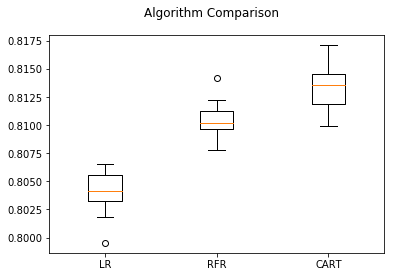

In [9]:


import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# prepare configuration for cross validation test harness
seed = 7

models = []
models.append(('LR', LogisticRegression()))
models.append(('RFR', RandomForestClassifier()))
models.append(('CART', DecisionTreeClassifier()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_train,y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
